Copyright **`(c)`** 2023 Antonio Ferrigno `<s316467@polito.it>`  
[`https://github.com/s316467/Computational-Intelligence-23-24/tree/main`](https://github.com/s316467/Computational-Intelligence-23-24/tree/main)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/s316467/Computational-Intelligence-23-24/tree/main/LICENSE.md) for details.  


# Lab 2: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside the course repo 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



## Changes Made Prior to the Modification of the Lab Slides:

Initially, the lab did not specify which version of the Nim game we were to play, so we adhered to the official Nim game rules as outlined on the Archimedes Lab website ([`https://www.archimedes-lab.org/How_to_Solve/Win_at_Nim.html`](https://www.archimedes-lab.org/How_to_Solve/Win_at_Nim.html)), which allows simulation of a Nim game. In this version, the player who removes the last piece and thus makes the final move is considered the loser. Based on this, the following considerations and changes were made:

- **optimal() => Incorrect Logic:**

  In defining the "spicy_moves" (the moves that result in a state with a nim_sum of 0), the line `"spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]"` is incorrect. It only considers moves where the nim_sum is not 0 (`if ns != 0`). Therefore, the agent will always make a random play from all the possible remaining moves.

- **optimal() => Final Moves:**

  Based on the function's definition (once corrected to `ns == 0` instead of `ns != 0`), the agent will often lose even when it starts second, which should be impossible according to the game rules ("[...] the player who starts the game first will obviously lose if his opponent maintains a zero “Nim sum” configuration throughout the game [...]," see -> [`https://www.archimedes-lab.org/How_to_Solve/Win_at_Nim.html`](https://www.archimedes-lab.org/How_to_Solve/Win_at_Nim.html)). This happens because when the agent needs to make the final moves that will lead to victory (by removing a certain number of elements from a row, leaving just one element in total), it always selects the move with a nim_sum of 0 if one exists. This move often involves removing all elements in the state, leading to a [0 0 0 0 0] configuration with a nim_sum of 0. This move will invariably lead to defeat, even against the random_choice method, and even if the agent starts second.

- **optimal_def() => Correct Implementation:**

  To ensure correct behavior for both "normal moves" (those that are not the final move leaving only one element in the configuration) and "final moves," we added a control. After playing a possible move, it sums all the remaining values of the configuration. If the sum is 1, then that move will be the final move leading to victory.

- **Old Implementation of optimal():**
  ```python
  def optimal(state: Nim) -> Nimply:
      analysis = analyze(state)
      logging.debug(f"analysis:\n{pformat(analysis)}")
      spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
      if not spicy_moves:
          spicy_moves = list(analysis["possible_moves"].keys())
      ply = random.choice(spicy_moves)
      return ply
  ```


## After the modification of the lab's slides:

Based on the latest version of the slide the version of the nim game proposed is the one in which the player who plays the last move by removing the last piece is considered the winner. In this way the only modification necessary is the one within the 'optimal' strategy in which the line of code must be corrected:

- spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0] -> put ns == 0 instead (see above for the explanation)

In [1]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy


## The *Nim* and *Nimply* classes

In [2]:
Nimply = namedtuple("Nimply", "row, num_objects")


In [3]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self.initial_rows = [i * 2 + 1 for i in range(num_rows)]  # Store the initial configuration
        self._rows = self.initial_rows.copy()  # Start with the initial configuration
        self._k = k


    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects
        
    def reset(self):
        self._rows = self.initial_rows.copy()

## Sample (and silly) startegies 

In [4]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)


In [5]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [6]:
def adaptive(state: Nim) -> Nimply: ## Initial propostal for EA strategy
    """A strategy that can adapt its parameters"""
    genome = {"love_small": 0.5}


In [7]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


## modified version of oprimal -> put ns == 0 instead of ns != 0
def optimal_def(state: Nim) -> Nimply: 
    analysis = analize(state)
    #logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns == 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply


## First implementation of the optimal_def strategy before the modification of the lab's slides
#def optimal_def(state: Nim) -> Nimply:
    analysis = analize(state)
    ##logging.debug(f"analysis:\n{pformat(analysis)}")

    # Initialize the best move and the minimum sum after the move to be the worst case
    best_ply = None
    min_sum_after_move = float('inf')
    spicy_moves = list()

    # Evaluate each possible move
    for ply, ns in analysis["possible_moves"].items():
        tmp = deepcopy(state)
        tmp.nimming(ply)
        
        # Calculate the sum of objects after the move
        sum_after_move = sum(tmp.rows)
        
        # If the sum after move is 1, it's the best move as it forces the opponent to take the last object
        if sum_after_move == 1:
            return ply
        
        # If the num_sum of ply is 0 this will be one of the best moves to play that is not a final move
        if ns == 0:
            spicy_moves.append(ply)

    # If there aren't any moves with nim_sum equal to 0 then insert all the possible moves in "spicy_moves" and then play randomly one of it
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())

    ##logging.info(f"Spicy_moves:\n{pformat(spicy_moves)}")  

    # If no move results in the sum of 1, choose one of the "spicy_moves"
    return best_ply if best_ply else random.choice(spicy_moves)

## Prof's implementation of the optimal strategy
def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply



With our optimal version, 

## Evolutional Strategy approach

In [8]:
import random

number_of_games = 100  # define the number of games each agent should play to evaluate its fitness
perfect_score = number_of_games * 2  # Perfect score should now consider the speed of winning

class NimAgent:
    def __init__(self, genome):
        self.genome = genome

    def make_move(self, state):
        # Compute the XOR of all rows
        xor_sum = 0
        for count in state.rows:
            xor_sum ^= count
        
        if xor_sum == 0:
            # If the XOR sum is already 0, we're in a losing state, so fall back to genome preferences
            return self.fallback_move(state)
        else:
            # Otherwise, make the move that leads to a balanced (XOR 0) state
            for row, count in enumerate(state.rows):
                if count > 0:
                    target_count = xor_sum ^ count
                    if target_count < count:
                        # We found a move that leads to a balanced state
                        return Nimply(row, count - target_count)
            # If we didn't find a balancing move, fallback to the genome-based strategy
            return self.fallback_move(state)

    def fallback_move(self, state):
        # moves are tuples of (row, num_objects), where num_objects is between 1 and the number of objects in the row multiplied by the genome value
        moves = [
            (row, min(state.rows[row], max(1, int(self.genome[row] * state.rows[row]))))
            for row in range(len(state.rows)) if state.rows[row] > 0
        ]

        # Select the move with the highest preference
        # the highest preference is the onw with the highest genome value
        chosen_move = max(moves, key=lambda x: self.genome[x[0]])

        # Return the move
        return Nimply(*chosen_move)

def crossover(genome1, genome2):
    # Implemented uniform crossover
    # Creates a child genome by randomly selecting each gene from either parent with equal probability.
    child_genome = [g1 if random.random() > 0.5 else g2 for g1, g2 in zip(genome1, genome2)]
    return child_genome

def mutate(genome, mutation_rate):
    # Ensure genome is within bounds after mutation
    for i in range(len(genome)):
        if random.random() < mutation_rate:
            mutation = random.choice([-1, 1]) * random.random()
            genome[i] = min(max(genome[i] + mutation, 0), 1)  # Keep genome within [0, 1]
    return genome

def select_agents(population, fitness_scores):
    # Logic to select the fittest agents
    # Let's use a simple tournament selection
    selected = []
    while len(selected) < len(population) // 2:
        participant = random.sample(list(zip(population, fitness_scores)), 2)
        winner = max(participant, key=lambda x: x[1])
        selected.append(winner[0])
    return selected


def initialize_population(pop_size, genome_length):
    population = [NimAgent([random.random() for _ in range(genome_length)]) for _ in range(pop_size)]
    return population

def evaluate_population(population, nim):
    fitness_scores = []

    for agent in population:
        score = 0
        # Play a number of games and record the score
        for _ in range(number_of_games):
            nim.reset()  # Reset the game to initial state
            moves = 0
            while nim:
                ply = agent.make_move(nim)
                nim.nimming(ply)
                moves += 1
                if not nim:
                    score += 2  # Win gets double score
            score -= moves  # Deduct the number of moves to encourage quicker wins
        fitness_scores.append(score)
    
    return fitness_scores

def reproduce(selected_agents, mutation_rate):
    new_population = []

    while len(new_population) < len(selected_agents):
        parent1, parent2 = random.sample(selected_agents, 2)
        child_genome = crossover(parent1.genome, parent2.genome)
        child_genome = mutate(child_genome, mutation_rate)
        new_population.append(NimAgent(child_genome))
    
    return new_population

def replacement(population, new_population, fitness_scores):
    # Sort the population by fitness and replace the worst ones
    sorted_population = sorted(zip(population, fitness_scores), key=lambda x: x[1], reverse=True)
    survivors = sorted_population[:len(population) - len(new_population)]
    # In the end half of the population will be changed and the other half will be preserved
    return [agent for agent, score in survivors] + new_population

def evolutionary_strategy(nim, generations, pop_size, initial_mutation_rate):
    population = initialize_population(pop_size, len(nim.rows))
    avg_moves_per_game_history = []
    best_individual = None
    best_fitness = -1
    mutation_rate = initial_mutation_rate
    avg_moves_per_game_history = []

    for generation in range(generations):
        fitness_scores = evaluate_population(population, nim)
        
        # Compute the average number of moves per game for the current generation
        avg_moves_per_game = sum(fitness_scores) / len(fitness_scores)
        avg_moves_per_game_history.append(avg_moves_per_game)
        
        # The best score is halved to report the number of wins, since each win is worth double points in the scoring system.
        print(f"Generation {generation}: Best score {max(fitness_scores) // 2} wins, Avg moves per game: {sum(fitness_scores) / len(fitness_scores)}")
        

        # Check for termination condition (e.g., a perfect score)
        if max(fitness_scores) >= -perfect_score:
            print("Stopping early, reached perfect score!")
            break

        # Selection
        selected_agents = select_agents(population, fitness_scores)

        # Reproduction
        new_population = reproduce(selected_agents, mutation_rate)

        # Replacement
        population = replacement(population, new_population, fitness_scores)

        # Check if the new best individual is found
        max_fitness = max(fitness_scores)
        if max_fitness > best_fitness:
            best_fitness = max_fitness
            best_individual_index = fitness_scores.index(max_fitness)
            best_individual = population[best_individual_index]
        # Optionally, adapt the mutation rate
        # This can be a function of the progress stagnation, diversity in population, etc.

    return population, avg_moves_per_game_history





## Oversimplified match

Generation 0: Best score -200 wins, Avg moves per game: -824.0
Generation 1: Best score -200 wins, Avg moves per game: -628.0
Generation 2: Best score -200 wins, Avg moves per game: -524.0
Generation 3: Best score -200 wins, Avg moves per game: -500.0
Generation 4: Best score -200 wins, Avg moves per game: -436.0
Generation 5: Best score -200 wins, Avg moves per game: -448.0
Generation 6: Best score -200 wins, Avg moves per game: -464.0
Generation 7: Best score -200 wins, Avg moves per game: -448.0
Generation 8: Best score -200 wins, Avg moves per game: -440.0
Generation 9: Best score -200 wins, Avg moves per game: -456.0


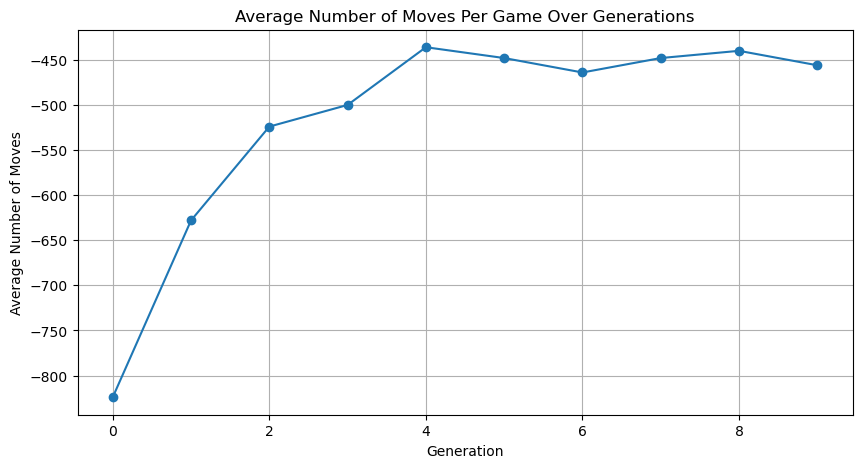

INFO:root:Initial state: <1 3 5 7>


Best agent index: 0
Best agent: [0.4582322300248821, 0.6442164336732928, 0.7085110910326208, 0.23849358786672747]


In [9]:
import logging
import matplotlib.pyplot as plt
import itertools

# Set the logging level to INFO to see the details of the game play
logging.getLogger().setLevel(logging.INFO)

# Set parameters for the evolutionary strategy
num_rows = 4  # number of rows in the Nim game
generations = 10  # number of generations to run the evolution
pop_size = 50  # size of the agent population
mutation_rate = 0.15  # mutation rate for the evolutionary strategy

# Initialize the Nim game
nim_game = Nim(num_rows)


# Run the evolutionary strategy to get a population of evolved agents
evolved_population, avg_moves_per_game_history = evolutionary_strategy(nim_game, generations, pop_size, mutation_rate)

# Plot the average number of moves per game over generations
plt.figure(figsize=(10, 5))
plt.plot(avg_moves_per_game_history, marker='o')
plt.title('Average Number of Moves Per Game Over Generations')
plt.xlabel('Generation')
plt.ylabel('Average Number of Moves')
plt.grid()
plt.show()

# Evaluate the final population to find the best agent from ES
fitness_scores = evaluate_population(evolved_population, nim_game)
best_agent_index = fitness_scores.index(max(fitness_scores))
print("Best agent index: " + str(best_agent_index))
best_agent = evolved_population[best_agent_index]
print("Best agent: " + str(best_agent.genome))

# Now let's play a game
nim = Nim(num_rows)
player = 0  # Let's say our expert system is player 0

logging.info(f"Initial state: {nim}")

def print_nim(nim):
    print("\nCurrent game state:")
    for row, num_objects in enumerate(nim.rows):
        print("Row {}: {}".format(row, "I" * num_objects))
    print("\n")

def play_game(strategy1, strategy2, num_rows):
    """Play a game of Nim between two strategies."""
    nim = Nim(num_rows)
    player = 0  # Start with player 0
    while nim:
        if player == 0:
            ply = strategy1(nim)
        else:
            ply = strategy2(nim)
        nim.nimming(ply)
        if not nim:
            return player  # Return the winning player
        player = 1 - player  # Switch player
   

## Data Analysis

Strategies: 
dict_keys(['optimal', 'pure_random', 'gabriele', 'optimal_def', 'best_agent'])

Matchups: 

('optimal', 'pure_random')
('pure_random', 'optimal')
('optimal', 'gabriele')
('gabriele', 'optimal')
('optimal', 'optimal_def')
('optimal_def', 'optimal')
('optimal', 'best_agent')
('best_agent', 'optimal')
('pure_random', 'gabriele')
('gabriele', 'pure_random')
('pure_random', 'optimal_def')
('optimal_def', 'pure_random')
('pure_random', 'best_agent')
('best_agent', 'pure_random')
('gabriele', 'optimal_def')
('optimal_def', 'gabriele')
('gabriele', 'best_agent')
('best_agent', 'gabriele')
('optimal_def', 'best_agent')
('best_agent', 'optimal_def')


Tranches: 

1) ['optimal' vs 'pure_random']
Game 1 -> Winner: Player1
Game 2 -> Winner: Player1
Game 3 -> Winner: Player0
Game 4 -> Winner: Player0
Game 5 -> Winner: Player1
Game 6 -> Winner: Player1
Game 7 -> Winner: Player0
Game 8 -> Winner: Player1
Game 9 -> Winner: Player1
Game 10 -> Winner: Player0

2) ['optimal' vs 'gabriele']
Ga

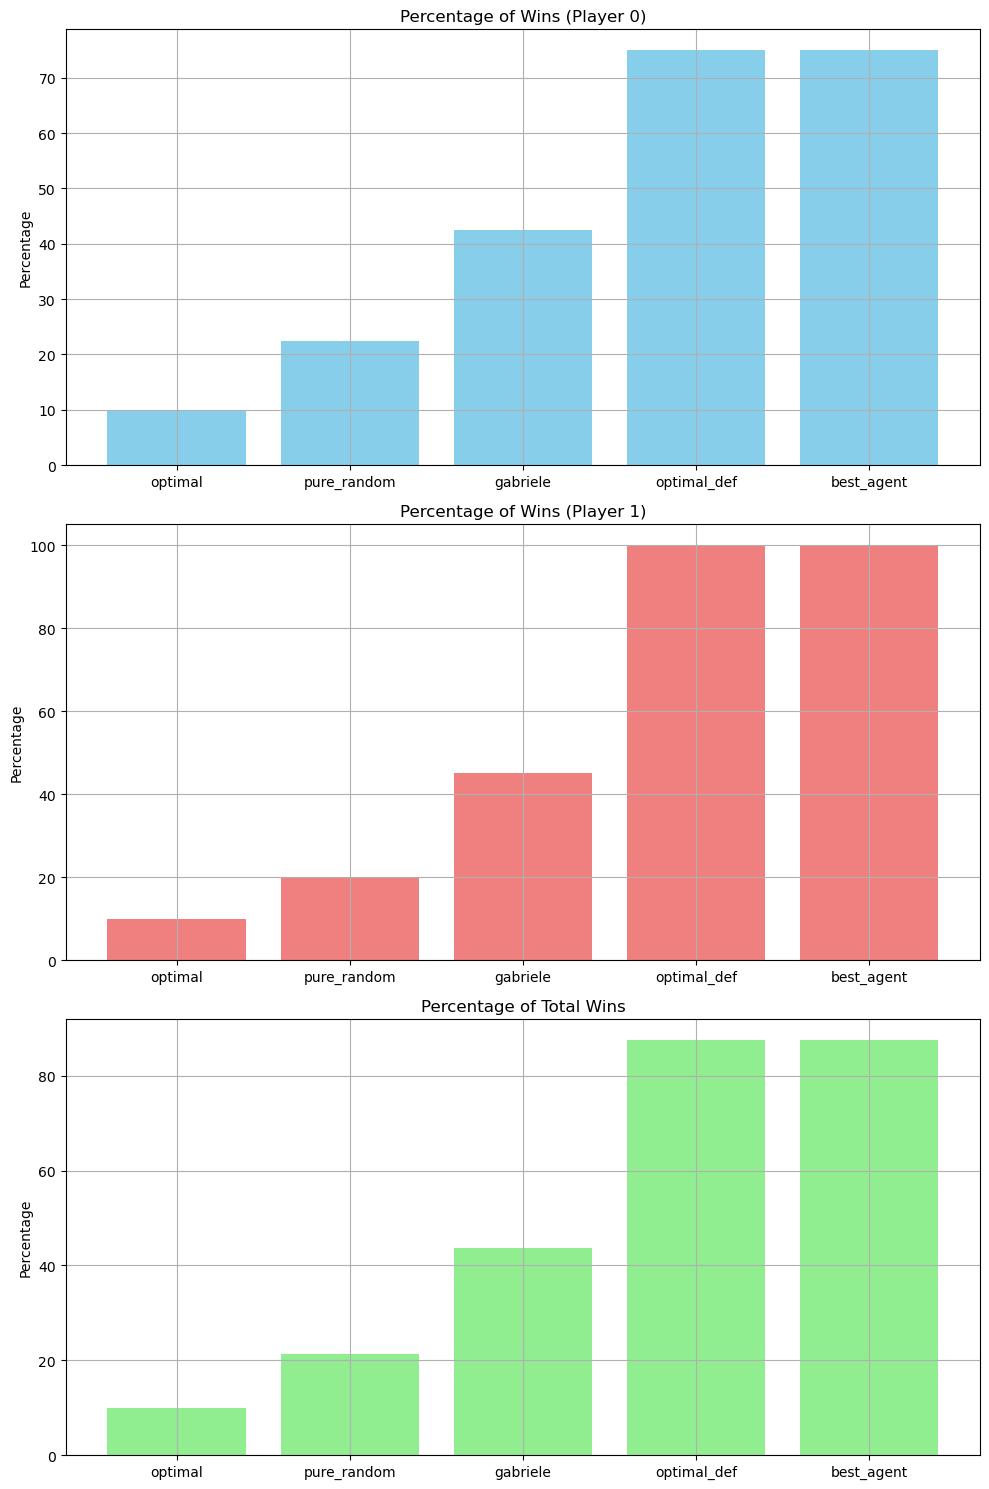

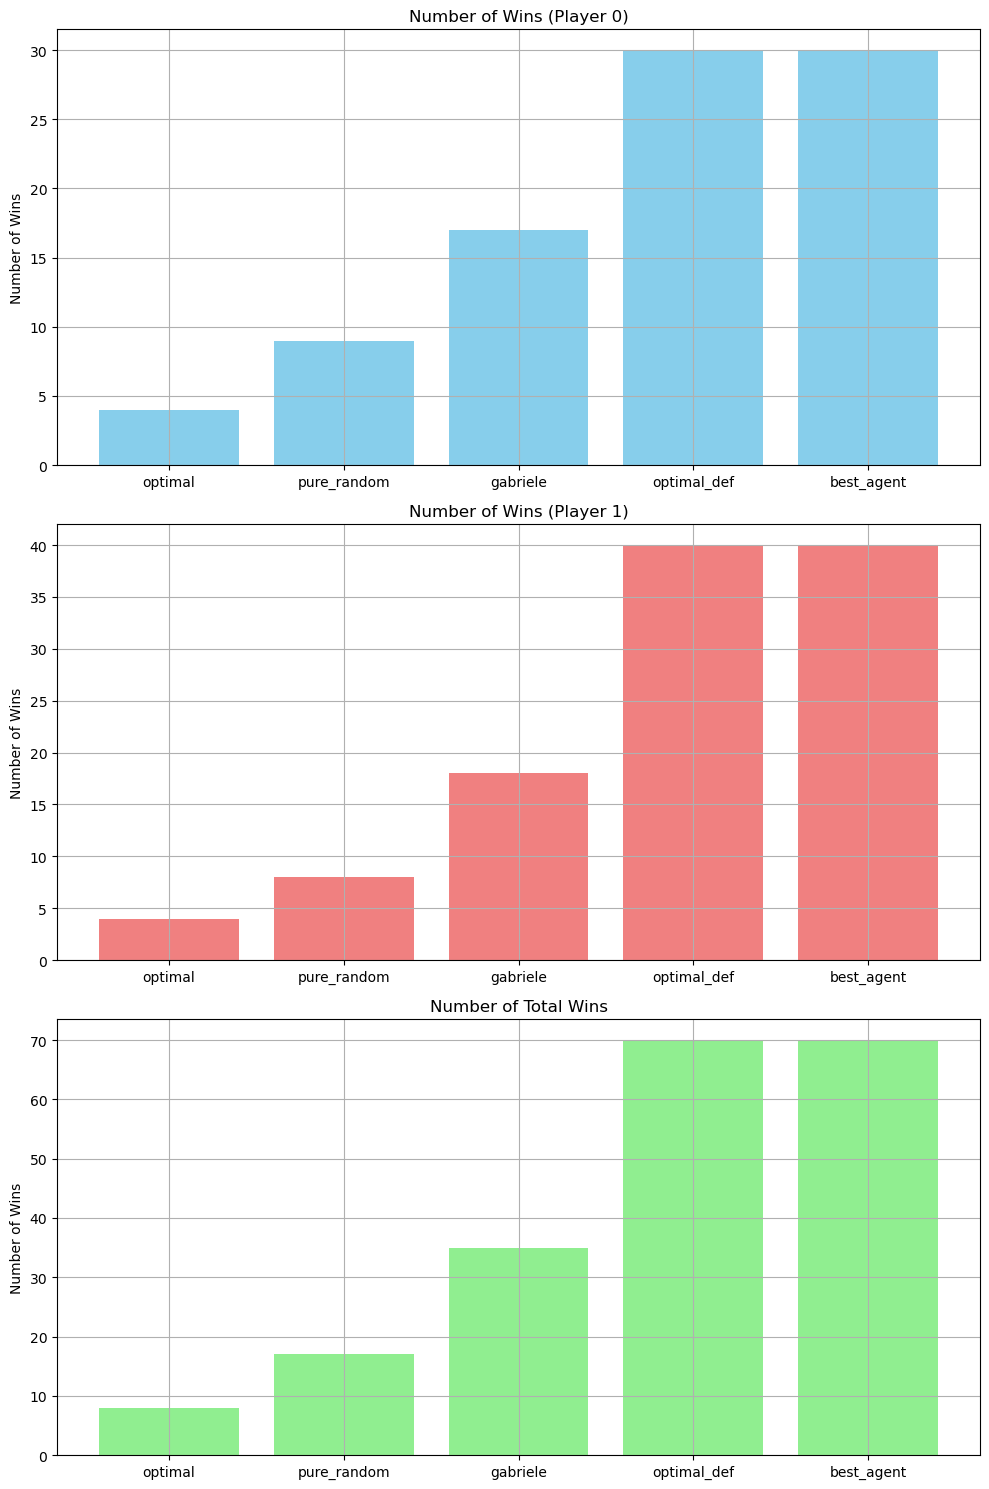

In [10]:
import itertools
import matplotlib.pyplot as plt


# A dictionary containing all the proposed strategies 
class Strategies:
    def __init__(self):
        self.strategies = {
            "optimal": optimal,
            "pure_random": pure_random,
            "gabriele": gabriele,
            "optimal_def": optimal_def,
            "best_agent": best_agent.make_move
        }


# A class that define all the possible matchup among the strategies
class Matchup:
    def __init__(self, strategies):
        self.matchups = list(itertools.combinations(strategies, 2))

    # Generate all the matchups
    def generate_matchups(self):
        return self.matchups

    # Generate all the matchups without repetition (for example we cannot have (optimal, optimal))
    def generate_all_matchups(self):
        return [(a, b) for a, b in self.matchups] + [(b, a) for a, b in self.matchups]

    # Generate all the matchups with repetition (so (optimal, optimal) is admissible)
    def generate_matchups_with_repetition(self):
        return [(a, b) for a, b in self.matchups] + [(b, a) for a, b in self.matchups] + [(a, a) for a, b in self.matchups if (a, a) not in self.matchups] 

    # Generate all the possible matchups for a specific strategy
    def generate_specified_matchups(self, specific_strategy):
        # Generate matchups only for the specified strategy
        return [(a, b) for a, b in self.matchups if specific_strategy in (a, b)] + [(b, a) for a, b in self.matchups if specific_strategy in (b, a)]


# A class containing all the statistics about the tournament among all the strategies
class Tournament_Info:
    def __init__(self, strategies):
        self.strategy_stats = {strategy: {'total_wins': 0, 'player0_wins': 0, 'player1_wins': 0, 'total_games': 0, 'total_games_player0': 0, 'total_games_player1': 0} for strategy in strategies}

    def update_stats(self, winner, strategy_player0, strategy_player1):
        self.strategy_stats[strategy_player0]['total_games'] += 1
        self.strategy_stats[strategy_player1]['total_games'] += 1
        self.strategy_stats[strategy_player0]['total_games_player0'] += 1
        self.strategy_stats[strategy_player1]['total_games_player1'] += 1
        self.strategy_stats[strategy_player0]['total_wins'] += 1 if winner == 0 else 0
        self.strategy_stats[strategy_player1]['total_wins'] += 1 if winner == 1 else 0
        self.strategy_stats[strategy_player0]['player0_wins'] += 1 if winner == 0 else 0
        self.strategy_stats[strategy_player1]['player1_wins'] += 1 if winner == 1 else 0


# Play each game between 2 strategies num_games time (default 10) and update the statistics
def play_tournament(matchups, tournament_info, num_games=10):
    i = 1
    for strategy1, strategy2 in matchups:
        print(f"\n{i}) ['{strategy1}' vs '{strategy2}']")
        i += 1
        for _ in range(num_games):
            winner = play_game(strategies.strategies[strategy1], strategies.strategies[strategy2], num_rows)
            print(f"Game {_ + 1} -> Winner: Player{winner}")
            tournament_info.update_stats(winner, strategy1, strategy2)


# Create instances of the classes
strategies = Strategies()
matchup = Matchup(strategies.strategies.keys())
tournament_info = Tournament_Info(strategies.strategies.keys())

# Print the strategies
print(f"Strategies: \n{strategies.strategies.keys()}")

# The matchup.matchups variable contains all the matchup without inverted duplicates 
# (for example it contains (optimal, gabriele) but not (gabriele, optimal))
# This because the "play_tournament" function already consider all the strategies in matchup in both position
# so each tuple of strategies will be assigned both to player0 and player1 and viceversa
# To visualize all the possible matchups we print every element of the matchup.matchups variable 
# and his reversed version as seen above
print(f"\nMatchups: \n")
for match in matchup.matchups:
    print(match)
    # Print the reverse of the tuple
    reverse_match = (match[1], match[0])
    print(reverse_match)    

# Generate matchups only for "optimal_def"
# optimal_def_matchups = matchup.generate_specified_matchups("optimal_def")

# Play the tournament
print(f"\n\nTranches: ")
play_tournament(matchup.generate_all_matchups(), tournament_info)
# play_tournament(matchup.generate_specified_matchups("optimal_def"), tournament_info)


##############################################

# Print the statistics about the single strategies
print(f"\n\nSTATISTICS:\n")
for strategy in strategies.strategies.keys():
    stats = tournament_info.strategy_stats[strategy]
    print(f"\nStrategy: {strategy}")
    print(f"Total Games: {stats['total_games']}")
    print(f"Total Wins: {stats['total_wins']}")
    print(f"Percentage of Total Wins: {stats['total_wins'] / stats['total_games'] * 100:.2f}%")
    
    # Check if total games as player0 is zero
    if stats['total_games_player0'] > 0:
        print(f"Total Games as player0: {stats['total_games_player0']}")
        print(f"Number of wins as Player 0: {stats['player0_wins']}")
        print(f"Percentage of Wins (Player 0): {stats['player0_wins'] / stats['total_games_player0'] * 100:.2f}%")
    else:
        print("No games played as player0")
    
    
    # Check if total games as player1 is zero
    if stats['total_games_player1'] > 0:
        print(f"Total Games as player1: {stats['total_games_player1']}")
        print(f"Number of wins as Player 1: {stats['player1_wins']}")
        print(f"Percentage of Wins (Player 1): {stats['player1_wins'] / stats['total_games_player1'] * 100:.2f}%")
    else:
        print("No games played as player1")
    print("-" * 30)


# Calculate percentages
percentages_player0 = [tournament_info.strategy_stats[strategy]['player0_wins'] / tournament_info.strategy_stats[strategy]['total_games_player0'] * 100 if tournament_info.strategy_stats[strategy]['total_games_player0'] > 0 else 0 for strategy in strategies.strategies]
percentages_player1 = [tournament_info.strategy_stats[strategy]['player1_wins'] / tournament_info.strategy_stats[strategy]['total_games_player1'] * 100 if tournament_info.strategy_stats[strategy]['total_games_player1'] > 0 else 0 for strategy in strategies.strategies]
percentages_total = [tournament_info.strategy_stats[strategy]['total_wins'] / tournament_info.strategy_stats[strategy]['total_games'] * 100 if tournament_info.strategy_stats[strategy]['total_games'] > 0 else 0 for strategy in strategies.strategies]


##############################################

# Plot percentages
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Player 0
axes[0].bar(strategies.strategies.keys(), percentages_player0, color='skyblue')
axes[0].set_title('Percentage of Wins (Player 0)')
axes[0].set_ylabel('Percentage')
axes[0].grid()

# Player 1
axes[1].bar(strategies.strategies.keys(), percentages_player1, color='lightcoral')
axes[1].set_title('Percentage of Wins (Player 1)')
axes[1].set_ylabel('Percentage')
axes[1].grid()

# Total
axes[2].bar(strategies.strategies.keys(), percentages_total, color='lightgreen')
axes[2].set_title('Percentage of Total Wins')
axes[2].set_ylabel('Percentage')
axes[2].grid()

plt.tight_layout()
plt.show()

# Plot number of wins
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Player 0
axes[0].bar(strategies.strategies.keys(), [tournament_info.strategy_stats[strategy]['player0_wins'] for strategy in strategies.strategies], color='skyblue')
axes[0].set_title('Number of Wins (Player 0)')
axes[0].set_ylabel('Number of Wins')
axes[0].grid()

# Player 1
axes[1].bar(strategies.strategies.keys(), [tournament_info.strategy_stats[strategy]['player1_wins'] for strategy in strategies.strategies], color='lightcoral')
axes[1].set_title('Number of Wins (Player 1)')
axes[1].set_ylabel('Number of Wins')
axes[1].grid()

# Total
axes[2].bar(strategies.strategies.keys(), [tournament_info.strategy_stats[strategy]['total_wins'] for strategy in strategies.strategies], color='lightgreen')
axes[2].set_title('Number of Total Wins')
axes[2].set_ylabel('Number of Wins')
axes[2].grid()

plt.tight_layout()
plt.show()
